# Spectral line imaging demonstration

Create a spectral line data set, add a grid components, multiply by the low BEAM, transform exactly to visibilities.

We remove the continuum in the image plane and in the visibility plane, using a second order term in frequency.

We will make use to graphs to speed the processing. These are based on dask.delayed.

In [1]:
%matplotlib inline

import os
import sys

from dask import delayed

sys.path.append(os.path.join('..', '..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from scipy.interpolate import interp1d

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.data.polarisation import PolarisationFrame
from arl.data.parameters import get_parameter
from arl.data.data_models import Visibility, BlockVisibility
from arl.visibility.operations import create_visibility, create_blockvisibility, copy_visibility, \
    remove_continuum_blockvisibility
from arl.visibility.coalesce import convert_blockvisibility_to_visibility
from arl.skycomponent.operations import create_skycomponent
from arl.skycomponent.operations import create_skycomponent, insert_skycomponent, apply_beam_to_skycomponent

from arl.image.deconvolution import deconvolve_cube, restore_cube
from arl.image.operations import show_image, export_image_to_fits, qa_image, remove_continuum_image
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter, vis_timeslice_iter
from arl.util.testing_support import create_named_configuration, create_low_test_beam
from arl.fourier_transforms.ftprocessor import predict_2d, invert_2d, create_image_from_visibility, \
    predict_skycomponent_visibility, predict_skycomponent_blockvisibility, residual_image, \
    invert_timeslice_single, invert_timeslice_single, \
    predict_timeslice_single, predict_timeslice_single,advise_wide_field
from arl.pipelines.dask_graphs import create_invert_graph
from arl.pipelines.generic_dask_graphs import create_generic_blockvisibility_graph, create_generic_image_graph

import logging

log = logging.getLogger()
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler(sys.stdout))

We create the visibility. 

In [2]:
lowcore = create_named_configuration('LOWBD2-CORE')
times = numpy.linspace(-3,+3,3) * (numpy.pi / 12.0)
vnchan=33
frequency = numpy.linspace(1e8, 1.5e8, vnchan)
fitting_mask = numpy.ones([vnchan], dtype='bool')
fitting_mask[vnchan//4:3*vnchan//4] = False
print(fitting_mask)

channel_bandwidth = numpy.array(vnchan*[(frequency[1]-frequency[0])])
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox=2000.0)
vt = create_blockvisibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame("stokesI"))

[ True  True  True  True  True  True  True  True False False False False
 False False False False False False False False False False False False
  True  True  True  True  True  True  True  True  True]
create_visibility: 3 rows, 0.063 GB


Create a grid of components

In [3]:
npixel = 256
cellsize=0.0007
flux = numpy.array(vnchan*[[100.0]])
facets = 4
model = create_image_from_visibility(vt, npixel=npixel, cellsize=cellsize, npol=1, frequency=frequency,
                                    polarisation_frame=PolarisationFrame("stokesI"))
model_graph=delayed(model)
spacing_pixels = npixel // facets
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = 180.0 * cellsize * spacing_pixels / numpy.pi
centers = -1.5, -0.5, +0.5, +1.5
comps = list()
for iy in centers:
    for ix in centers:
        pra =  int(round(npixel // 2 + ix * spacing_pixels - 1))
        pdec = int(round(npixel // 2 + iy * spacing_pixels - 1))
        sc = pixel_to_skycoord(pra, pdec, model.wcs)
        log.info("Component at (%f, %f) %s" % (pra, pdec, str(sc)))
        comps.append(create_skycomponent(flux=flux, frequency=frequency, direction=sc, 
                                         polarisation_frame=PolarisationFrame("stokesI")))


create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining 33 channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1562500.0 Hz
create_image_from_visibility: uvmax = 396.276693 wavelengths
create_image_from_visibility: Critical cellsize = 0.001262 radians, 0.072293 degrees
create_image_from_visibility: Cellsize          = 0.000700 radians, 0.040107 degrees
Spacing in pixels = 64
Component at (31.000000, 31.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 20.8454813, -48.71387437)>
Component at (95.000000, 31.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 16.95029555, -48.83769826)>
Component at (159.000000, 31.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 13.04970445, -48.83769826)>
Component at (223.000000, 31.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 9.1545187, -48.71387437)>
Component at (31.000000, 95.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 2

Apply LOW Beam to components and make then execute and graph to predict the visibilities.

In [4]:
bm = create_low_test_beam(model=model)
sc = apply_beam_to_skycomponent(comps, bm)
vt = create_generic_blockvisibility_graph(predict_skycomponent_blockvisibility)(vt, vis_timeslice_iter, 
                                                                                comps).compute()

import_image_from_fits: Max, min in /Users/timcornwell/Code/algorithm-reference-library/data/models/SKA1_LOW_beam.fits = 0.997918, 0.000000
create_low_test_beam: primary beam is defined at 100.000 MHz


To make an image we need to convert to Visibility format

In [5]:
cvt=convert_blockvisibility_to_visibility(vt)

convert_visibility: Original 3 rows, 0.063 GB, converted 1355805 rows, 0.131 GB


Make and execute a graph to invert the visibility

In [6]:
dirty_imlin, sumwt = create_invert_graph(cvt, model_graph, 
                                         invert_single=invert_timeslice_single).compute()

Fit and remove the continuum in the dirty image. This is usually called IMLIN.

In [7]:
dirty_imlin = create_generic_image_graph(remove_continuum_image)(dirty_imlin, raster_iter, 
                                                                 deg=2, mask=fitting_mask, 
                                                                 facets=2).compute()
print(qa_image(dirty_imlin))

raster: predicting using 2 x 2 image partitions
raster: spacing of raster (128, 128)
raster: predicting using 2 x 2 image partitions
raster: spacing of raster (128, 128)
Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: (33, 1, 256, 256)
		max: 6.4255090148
		min: -3.08201467817
		rms: 0.518978308057
		sum: -746.935957157
		medianabs: 0.263285126127
		median: -0.006064771319



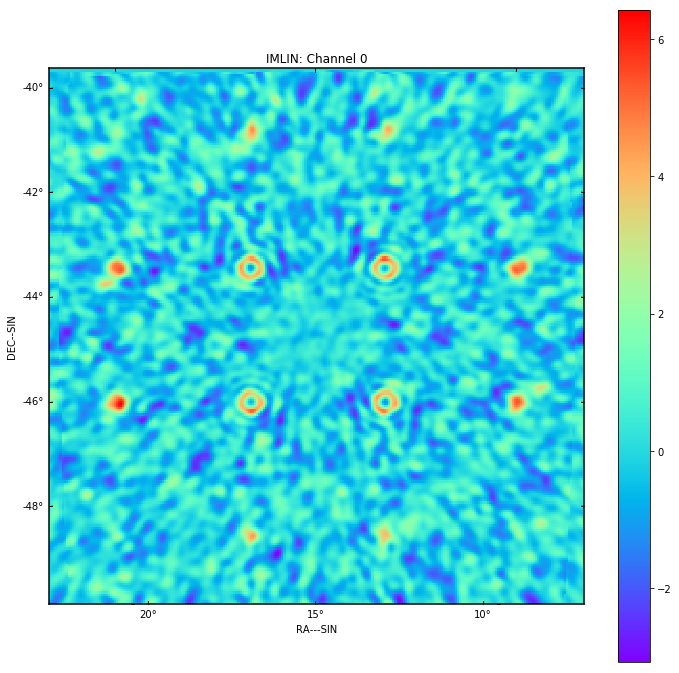

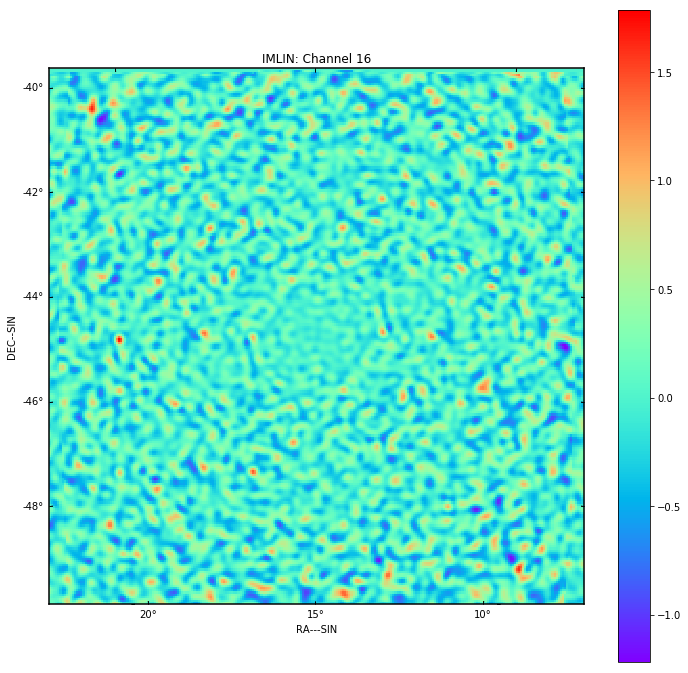

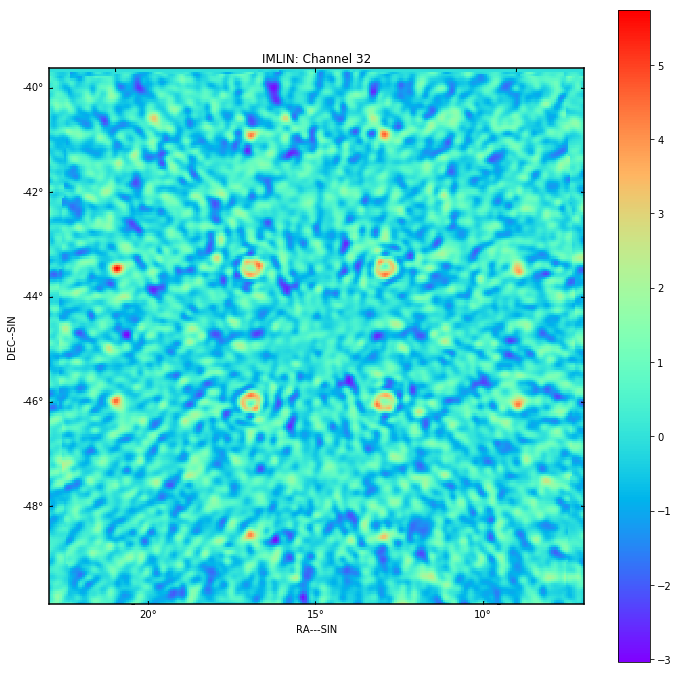

In [8]:
show_image(dirty_imlin, chan=0, title='IMLIN: Channel 0')
plt.show()
show_image(dirty_imlin, chan=16, title='IMLIN: Channel 16')
plt.show()
show_image(dirty_imlin, chan=32, title='IMLIN: Channel 32')
plt.show()

export_image_to_fits(dirty_imlin, '%s/imaging-spectral-imlin.fits' % (results_dir))

Fit and remove the continuum in the visibility. This is usually called UVLIN.

In [9]:
vt=create_generic_blockvisibility_graph(remove_continuum_blockvisibility)(vt, 
                                                                          vis_timeslice_iter, 
                                                                          deg=2,
                                                                          mask=fitting_mask).compute()

In [10]:
cmvt=convert_blockvisibility_to_visibility(vt)

convert_visibility: Original 3 rows, 0.063 GB, converted 1355805 rows, 0.131 GB


TypeError: 'Visibility' object is not iterable

In [ ]:
dirty_uvlin, sumwt=create_invert_graph(cmvt, model_graph, 
                                       invert_single=invert_timeslice_single).compute()
print(qa_image(dirty_uvlin))

In [ ]:
show_image(dirty_uvlin, chan=0, title='UVLIN: Channel 0')
plt.show()
show_image(dirty_uvlin, chan=16, title='UVLIN: Channel 16')
plt.show()
show_image(dirty_uvlin, chan=32, title='UVLIN: Channel 32')
plt.show()

export_image_to_fits(dirty_uvlin, '%s/imaging-spectral-uvlin.fits' % (results_dir))